# Compute weekly average for estimation of TTDs using EHS

This notebook converts the hourly data to weekly one to use the Ensemble Hydrograph Separation method.

In [9]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.append('../../')
import WATRES
sites = ['Pully_small_storage','Pully_large_storage','Lugano_small_storage','Lugano_large_storage','Basel_small_storage','Basel_large_storage']

def convert_data4EHS(site):
    df = pd.read_csv('../{0}/data/{0}.txt'.format(site), sep='\t')
    df['datetime'] = df['t'].apply(lambda x: WATRES.fractional_year_to_datetime(x))
    # Step 1: Convert the 'datetime' column to datetime format
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d-%H:%M:%S')
    
    # Step 2: Set 'datetime' as the index for easier resampling
    df.set_index('datetime', inplace=True)

    # Calculate the quartiles of the 'q' column
    q_quantiles = df['q'][-365*24:].quantile([0.25, 0.5, 0.75]).to_dict() 
    for key, value in q_quantiles.items():
        q_quantiles[key] = value * 24 * 7
    
    # Step 3: Resample the data to weekly frequency and aggregate
    # For columns 'p', 'pet', 'q', we compute the sum for each day
    weekly_data = df.resample('W').agg({
        'p': 'sum',
        'pet': 'sum',
        'q': 'sum'
    })
    
    # For columns 'Cp' and 'Cq', compute the weighted average where the weights are given by 'p'
    weekly_data['Cp'] = df['Cp'].resample('D').apply(lambda x: (x * df.loc[x.index, 'p']).sum() / df.loc[x.index, 'p'].sum())
    weekly_data['Cq'] = df['Cq'].resample('D').apply(lambda x: (x * df.loc[x.index, 'q']).sum() / df.loc[x.index, 'q'].sum())
    
    # Reset index if you want 'datetime' to be a regular column
    weekly_data.reset_index(inplace=True)
    
    # Add columns for each quartile with 0 or 1 depending on which quartile the 'q' value belongs to
    weekly_data['Q_quantile_0'] = (weekly_data['q'] <= q_quantiles[0.25]).astype(int)
    weekly_data['Q_quantile_1'] = ((weekly_data['q'] > q_quantiles[0.25]) & (weekly_data['q'] <= q_quantiles[0.5])).astype(int)
    weekly_data['Q_quantile_2'] = ((weekly_data['q'] > q_quantiles[0.5]) & (weekly_data['q'] <= q_quantiles[0.75])).astype(int)
    weekly_data['Q_quantile_3'] = (weekly_data['q'] > q_quantiles[0.75]).astype(int)


    # Now, weekly_data contains the weekly sum for p, pet, q, and the weighted averages for Cp and Cq.
    weekly_data.to_csv('../{0}/data/{0}_weekly_EHS.txt'.format(site), index=False)

In [10]:
for site in sites:
    convert_data4EHS(site)

/tmp/ipykernel_335/3857325416.py:33: RuntimeWarning: invalid value encountered in scalar divide
  weekly_data['Cp'] = df['Cp'].resample('D').apply(lambda x: (x * df.loc[x.index, 'p']).sum() / df.loc[x.index, 'p'].sum())
/tmp/ipykernel_335/3857325416.py:33: RuntimeWarning: invalid value encountered in scalar divide
  weekly_data['Cp'] = df['Cp'].resample('D').apply(lambda x: (x * df.loc[x.index, 'p']).sum() / df.loc[x.index, 'p'].sum())
/tmp/ipykernel_335/3857325416.py:33: RuntimeWarning: invalid value encountered in scalar divide
  weekly_data['Cp'] = df['Cp'].resample('D').apply(lambda x: (x * df.loc[x.index, 'p']).sum() / df.loc[x.index, 'p'].sum())
/tmp/ipykernel_335/3857325416.py:33: RuntimeWarning: invalid value encountered in scalar divide
  weekly_data['Cp'] = df['Cp'].resample('D').apply(lambda x: (x * df.loc[x.index, 'p']).sum() / df.loc[x.index, 'p'].sum())
/tmp/ipykernel_335/3857325416.py:33: RuntimeWarning: invalid value encountered in scalar divide
  weekly_data['Cp'] = df

# Looking at the TTD from EHS

In [11]:
site = sites[0]
pathEHS = '../{0}/save/'.format(site)

plt.figure()
for k in range(3):
    dfEHS = pd.read_csv(os.path.join(pathEHS, 'EHS_quantile{0}.txt'.format(k)), sep=" ")

<Figure size 640x480 with 0 Axes>

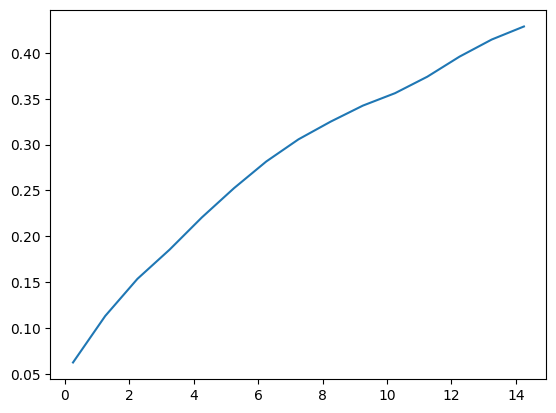

In [12]:
plt.plot(dfEHS['TTD_lag'], np.cumsum(dfEHS['QquantileTTD.TTD'])) 